# US Protest Data from various sources, 2020-2021
## Including some demographic info

In this notebook, we bring in and merge 3 datasets:
1. Protests in 2020-2021 (no attendee count)
2. Protests in 2020-2021 with attendee counts (and not much else)
3. Demographic dataset from 2015

The orignal datasets are inspected, unnecessary columns are dropped, unique IDs are created for dataset merging, and the final integrated dataset is saved in the Data folder.

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import re

# set random seed for whole notebook
np.random.seed(42)

This is our main dataset, to which 2 others will be merged: [ACLED Protest Data](https://acleddata.com/special-projects/us-crisis-monitor/)

In [211]:
df = pd.read_csv('../Data/Protest_US_2020.csv')

In [212]:
df.shape

(25607, 31)

In [213]:
df.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')

Information on columns, based on codebook:

* 'data_id': sequence this data was collected? Not in data dictionary
* 'iso': numeric code for each individual country
* 'event_id_cnty': identifier by number and country acronym e.g. USA25861
* 'event_id_no_cnty': individual numeric identifier e.g. 25861
* 'event_date': day, month, year on which event took place
* 'year': year even took place in
* 'time_precision': numeric code indicating level of certainty of the date coded for the event
* 'event_type': type of event e.g protests
* 'sub_event_type': type of sub-event e.g. protest with intervention, or peaceful protest
* 'actor1' (also 'actor2'): named actor involved in event e.g. Protestors
* 'assoc_actor_1' (also 'assoc_actor_2'): named actor associated with or identifying ACTOR 1 e.g. Students or Labor Group
* 'inter1' (also 'inter2'): numeric code indicating type of ACTOR1
* 'interaction': numeric code indicating interaction between types of ACTOR1 and ACTOR2
* 'region': North America
* 'country': United states
* 'admin1': State
* 'admin2': County
* 'admin3': null for all entries here
* 'location': City
* 'latitude': Latitude of the City
* 'longitude': Longitude of the City
* 'geo_precision': Numeric code indicating level of certainty of the location coded for the event
* 'source': Source of the event report e.g. Daily Freeman, KBJR6, Youtube
* 'source_scale': The scale (local, regional, national, international) of the source
* 'notes': Short description of the event
* 'fatalities': Number of reported fatalities which occurred during the event
* 'timestamp': Not in data dictionary
* 'iso3': Not in data dictionary

In [214]:
df.head(5)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,7740487,840,USA25861,25861,05 March 2021,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,North America,United States,Tennessee,Wilson,NaN,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0,1615330708,USA
1,7740234,840,USA25863,25863,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,North America,United States,Alabama,Jefferson,NaN,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0,1615330707,USA
2,7740252,840,USA25858,25858,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,North America,United States,Oregon,Deschutes,NaN,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0,1615330707,USA
3,7740288,840,USA25853,25853,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,North America,United States,New York,Ulster,NaN,Kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0,1615330707,USA
4,7740343,840,USA25848,25848,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,North America,United States,Minnesota,Saint Louis,NaN,Duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0,1615330707,USA


## Check for Missing Values

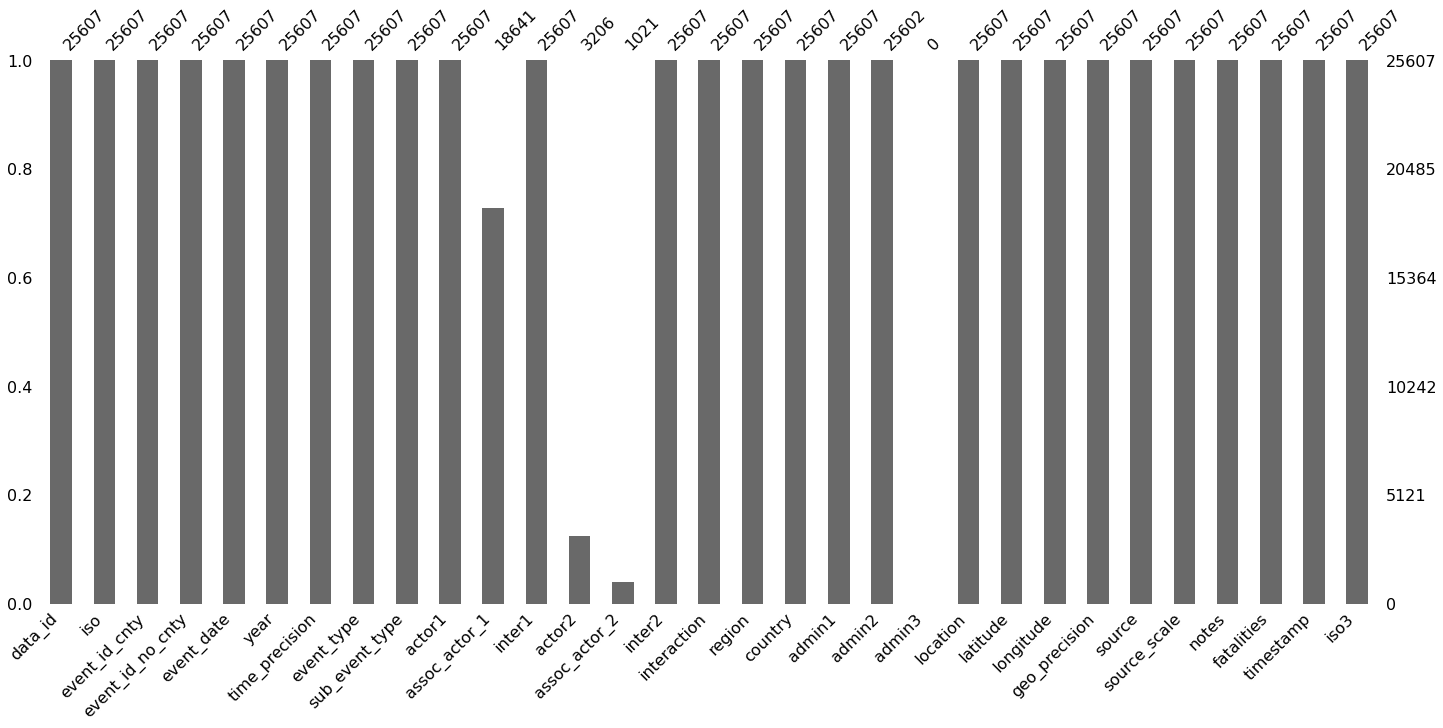

In [215]:
msno.bar(df);

* Most of the features are complete
* We would probably definitely discount actor2, assoc_actor_2, and admin3 since the majority of those are nulls
* assoc_actor_1 (the named actor associated with or identifying ACTOR1) is ~25% missing so perhaps discard that as well

In [216]:
# extract columns to keep
col_keep = ['event_date','year','time_precision','event_type','sub_event_type','actor1','assoc_actor_1','inter1',
           'actor2','assoc_actor_2','inter2','interaction','admin1','admin2','location','latitude','longitude','geo_precision','source','source_scale',
           'notes','fatalities']
protest = df[col_keep].copy()

col_dict = {'inter1':'type_actor1','inter2':'type_actor2','admin1':'state', 'admin2':'county', 'location':'city'}
protest.rename(columns=col_dict, inplace=True)
protest.head(3)

,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities
0,05 March 2021,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,Tennessee,Wilson,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0
1,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,Alabama,Jefferson,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0
2,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,Oregon,Deschutes,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0


In [217]:
protest.shape

(25607, 22)

New codebook:

* 'event_date': day, month, year on which event took place
* 'year': year even took place in
* 'time_precision': numeric code indicating level of certainty of the date coded for the event
* 'event_type': type of event e.g protests
* 'sub_event_type': type of sub-event e.g. protest with intervention, or peaceful protest
* 'actor1' (also 'actor2'): named actor involved in event e.g. Protestors
* 'assoc_actor_1' (also 'assoc_actor_2'): named actor associated with or identifying ACTOR 1 e.g. Students or Labor Group
* 'inter1' (also 'inter2'): numeric code indicating type of ACTOR1
* 'interaction': numeric code indicating interaction between types of ACTOR1 and ACTOR2
* 'state': State
* 'county': County
* 'city': City
* 'latitude': Latitude of the City
* 'longitude': Longitude of the City
* 'geo_precision': Numeric code indicating level of certainty of the location coded for the event
* 'source': Source of the event report e.g. Daily Freeman, KBJR6, Youtube
* 'source_scale': The scale (local, regional, national, international) of the source
* 'notes': Short description of the event
* 'fatalities': Number of reported fatalities which occurred during the event

## Check entries of each Column

### Year

In [218]:
# Should just be 2020 and 2021
protest['year'].value_counts()

2020    23249
2021     2358
Name: year, dtype: int64

### Time precision

In [219]:
# numeric code indicating level of certainty of the data coded for the event
df['time_precision'].value_counts(normalize=True, dropna=False)

1    0.992033
2    0.007654
3    0.000312
Name: time_precision, dtype: float64

99% of the recorded data comes with the highest level of certainty.

### Event Type

In [220]:
event_type = pd.DataFrame([protest['event_type'].value_counts(), protest['event_type'].value_counts(normalize=True)]).T
event_type.columns = ['count','fraction']
event_type

,count,fraction
Protests,23607.0,0.921896
Strategic developments,1027.0,0.040106
Riots,862.0,0.033663
Violence against civilians,98.0,0.003827
Battles,10.0,0.000391
Explosions/Remote violence,3.0,0.000117


92% of these entries are protests. We can probably one-hot-encode this feature.

### Sub Event Type

In [221]:
sub_event_type = pd.DataFrame([protest['sub_event_type'].value_counts(), protest['sub_event_type'].value_counts(normalize=True)]).T
sub_event_type.columns = ['count','fraction']
sub_event_type

,count,fraction
Peaceful protest,22655.0,0.884719
Protest with intervention,834.0,0.032569
Violent demonstration,815.0,0.031827
Other,626.0,0.024446
Change to group/activity,338.0,0.013200
Excessive force against protesters,118.0,0.004608
Attack,96.0,0.003749
Mob violence,47.0,0.001835
Arrests,30.0,0.001172
Looting/property destruction,22.0,0.000859


* 88% of these events were peaceful protests
* Surprised there is not more sexual violence reported at these protests
* Surprised there were events with grenade, suicide bomb, and remote explosive!

**Project idea: How does frequency of peaceful protests (or frequency of actual violence) correspond with news coverage of protest events?**

### Actor1

In [222]:
actor1 = pd.DataFrame([protest['actor1'].value_counts(), protest['actor1'].value_counts(normalize=True)]).T
actor1.columns = ['count','fraction']
actor1

,count,fraction
Protesters (United States),23591.0,0.921272
Rioters (United States),862.0,0.033663
Police Forces of the United States (2017-2021),172.0,0.006717
Government of the United States (2017-2021),130.0,0.005077
Civilians (United States),122.0,0.004764
...,...,...
North Coast Peace keepers,1.0,0.000039
"Police Forces of the United States (2017-2021) Bureau of Alcohol, Tobacco, Firearms and Explosives",1.0,0.000039
Patriot Response,1.0,0.000039
Prairie State Patriot Alliance,1.0,0.000039


It's interesting that there is a distinction between protestors and rioters. The number of events with 'rioters' is the same as the number of events classified as 'riots'. Which is good.

### Assoc Actor1

In [223]:
assoc_actor_1 = pd.DataFrame([protest['assoc_actor_1'].value_counts(dropna=False), 
                              protest['assoc_actor_1'].value_counts(dropna=False, normalize=True)]).T
assoc_actor_1.columns = ['count','fraction']
assoc_actor_1

,count,fraction
BLM: Black Lives Matter,7945.0,0.310267
NaN,6966.0,0.272035
Labour Group (United States),889.0,0.034717
Students (United States),885.0,0.034561
Women (United States),452.0,0.017651
...,...,...
BLM: Black Lives Matter; LGBT (United States); Women (United States); Civilians (United States); Journalists (United States),1.0,0.000039
Interfaith Group (United States); BLM: Black Lives Matter,1.0,0.000039
Women (United States); BLM: Black Lives Matter; NAACP: National Association for the Advancement of Colored People; African American Group (United States); PP: Planned Parenthood,1.0,0.000039
Pro-Police Group (United States); Blue Lives Matter; Former Police Forces of the United States (2017-2021),1.0,0.000039


### Type actor1

In [224]:
protest['type_actor1'].value_counts()

6    23608
5      862
1      504
3      270
4      239
7      123
8        1
Name: type_actor1, dtype: int64

Not entirely sure what this actually means.

### Actor2

In [225]:
actor2 = pd.DataFrame([protest['actor2'].value_counts(dropna=False), protest['actor2'].value_counts(dropna=False,normalize=True)]).T
actor2.columns = ['count','fraction']
actor2

,count,fraction
NaN,22401.0,0.874800
Police Forces of the United States (2017-2021),1335.0,0.052134
Protesters (United States),1106.0,0.043191
Civilians (United States),390.0,0.015230
Sole Perpetrator (United States),117.0,0.004569
Rioters (United States),111.0,0.004335
Police Forces of the United States (2021-),38.0,0.001484
Police Forces of the United States (2017-2021) Prison Guards,22.0,0.000859
Police Forces of the United States (2017-2021) Protecting American Communities Task Force,17.0,0.000664
Private Security Forces (United States),12.0,0.000469


### Assoc Actor2

In [226]:
assoc_actor_2 = pd.DataFrame([protest['assoc_actor_2'].value_counts(dropna=False), protest['assoc_actor_2'].value_counts(dropna=False,normalize=True)]).T
assoc_actor_2.columns = ['count','fraction']
assoc_actor_2

,count,fraction
NaN,24586.0,0.960128
BLM: Black Lives Matter,157.0,0.006131
African American Group (United States),99.0,0.003866
Pro-Police Group (United States),73.0,0.002851
Women (United States),32.0,0.001250
...,...,...
Government of the United States (2017-2021); Judges (United States),1.0,0.000039
Blue Lives Matter; Pro-Police Group (United States); Police Forces of the United States (2017-2021),1.0,0.000039
BLM: Black Lives Matter; Christian Group (United States),1.0,0.000039
WTP: We the People; BLM: Black Lives Matter,1.0,0.000039


### Type Actor2

In [227]:
protest['type_actor2'].value_counts()

0    22401
1     1444
6     1106
7      394
3      135
5      111
8       11
4        5
Name: type_actor2, dtype: int64

Not entirely sure what this actually means.

### Interaction

In [228]:
protest['interaction'].value_counts()

60    21551
66     1105
16      812
15      618
10      292
40      237
30      187
17      175
50      110
77      100
36       95
55       70
37       66
57       51
13       43
56       40
70       23
35        8
58        5
68        5
14        4
33        2
11        2
80        1
67        1
34        1
45        1
38        1
47        1
Name: interaction, dtype: int64

Not entirely sure what this actually means.

### State

In [229]:
# Found with help from Google
# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

def abbrev_states(state):
    return us_state_abbrev[state]

# abbreviated states
protest['state'] = protest['state'].apply(abbrev_states)
protest.head()

,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities
0,05 March 2021,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,TN,Wilson,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0
1,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,AL,Jefferson,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0
2,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,OR,Deschutes,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0
3,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,NY,Ulster,Kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0
4,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,MN,Saint Louis,Duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0


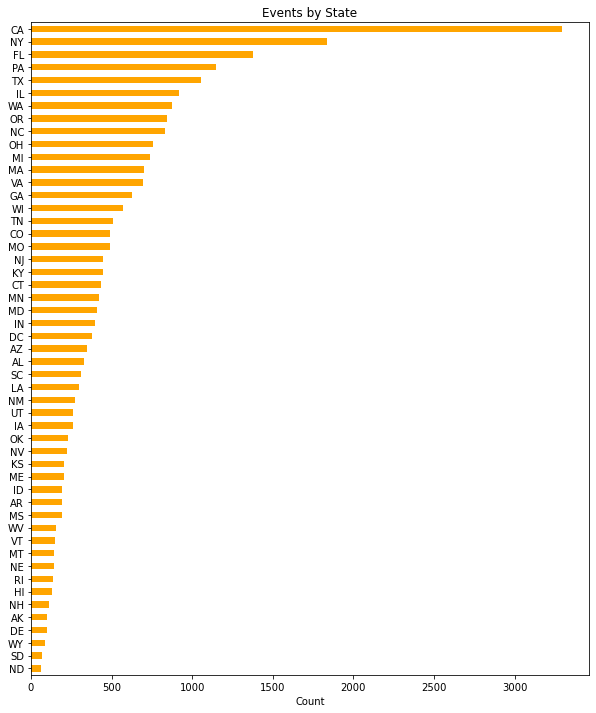

In [230]:
plt.figure(figsize=(10,12))
protest['state'].value_counts().sort_values().plot(kind='barh', color='orange')
plt.xlabel('Count')
plt.title("Events by State")
plt.show()

In [231]:
protest['state'].value_counts(normalize=True)[:10]

CA    0.128715
NY    0.071660
FL    0.053735
PA    0.044753
TX    0.041278
IL    0.035771
WA    0.034092
OR    0.032960
NC    0.032491
OH    0.029601
Name: state, dtype: float64

California, New York, Florida were the 3 states with the most protests, making up 25% of the total number of events.

### County

In [232]:
protest['county'].value_counts(dropna=False)[:10]

Los Angeles             702
New York                414
Cook                    379
District of Columbia    377
San Diego               353
Multnomah               349
Orange                  335
King                    294
Jefferson               283
Suffolk                 272
Name: county, dtype: int64

In [233]:
protest[protest['county']=='Cook'][['state']].value_counts()

state
IL       377
MN         2
dtype: int64

* It makes sense that LA and New York are the top 2 counties in which protests occur, since they're in California and New York, which are the 2 states where most protests occur
* Most of the entries for Cook are from Cook County in IL (though this is a good reminder that different states may have counties of the same name)
* Illinois is 6th on the list of states and Washington D.C. is exactly halfway down, but 2 of their cities are among the cities with the highest number of events. This means that some states have concentrated centers of protests whereas in other states, the events are distributed across the multiple cities in the state

In [234]:
protest.head()

,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities
0,05 March 2021,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,TN,Wilson,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0
1,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,AL,Jefferson,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0
2,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,OR,Deschutes,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0
3,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,NY,Ulster,Kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0
4,05 March 2021,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,MN,Saint Louis,Duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0


### Source Scale

In [235]:
protest['source_scale'].value_counts()

Subnational                  12253
Other-Subnational             6880
National                      2007
Other-National                 997
Other                          762
Subnational-National           699
Other-New media                608
Local partner-New media        596
New media                      239
New media-Subnational          215
Subnational-International       87
Other-International             79
International                   76
New media-National              56
National-International          28
New media-International         20
National-Regional                4
Other-Regional                   1
Name: source_scale, dtype: int64

### Fatalities

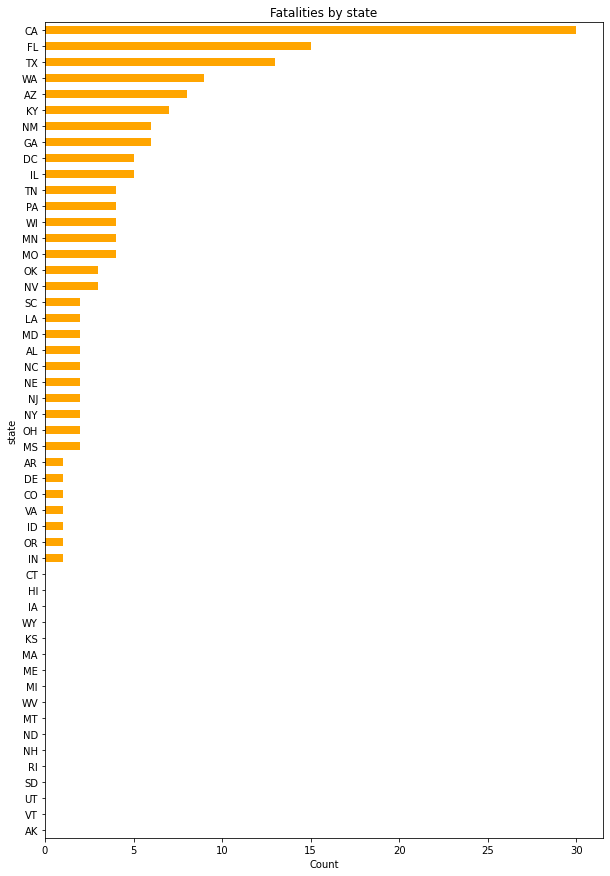

In [236]:
plt.figure(figsize=(10,15))
protest.groupby(by='state')['fatalities'].sum().sort_values().plot.barh(color='orange')
plt.title('Fatalities by state')
plt.xlabel('Count')
plt.show()

## Working with DateTime

In [237]:
# convert date to extract month and year
protest['event_date'] = pd.to_datetime(protest['event_date'])
protest['month'] = pd.DatetimeIndex(protest['event_date']).month

In [238]:
# rearrange columns
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
cols = list(protest.columns.values)
cols = cols[:1] + cols[-1:] + cols[1:-1]
protest = protest[cols]
protest.head()

,event_date,month,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities
0,2021-03-05,3,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,TN,Wilson,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0
1,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,AL,Jefferson,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0
2,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,OR,Deschutes,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0
3,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,NY,Ulster,Kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0
4,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,MN,Saint Louis,Duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0


In [239]:
protest["event_date"] = protest["event_date"].astype("datetime64")

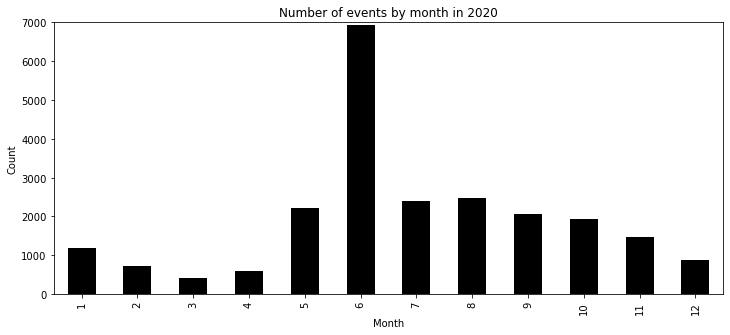

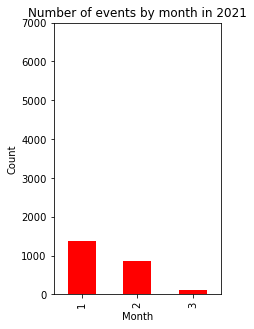

In [240]:
plt.figure(figsize=(12,5))
protest[protest['year']!=2021].groupby(protest["event_date"].dt.month)['event_date'].count().plot(kind="bar",color='black')
plt.title('Number of events by month in 2020')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 7000])
plt.show()

plt.figure(figsize=(3,5))
protest[protest['year']==2021].groupby(protest["event_date"].dt.month)['event_date'].count().plot(kind="bar",color='red')
plt.title('Number of events by month in 2021')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 7000])
plt.show()

* March: activity reduction when Covid shutdowns started
* June: protests related to George Floyd
* Jan 2021: protest levels similar to Jan 2020. But this is also when the Jan 6th US Capitol protests occured

In [241]:
protest.rename(columns={'event_date':'date'}, inplace=True)
protest.head()

,date,month,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities
0,2021-03-05,3,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,TN,Wilson,Mount Juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0
1,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,AL,Jefferson,Bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0
2,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,OR,Deschutes,Bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0
3,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,NY,Ulster,Kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0
4,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,MN,Saint Louis,Duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0


## Create unique ID for each event

In [242]:
# convert county, city, state, to lowercase snakecase
protest['county'] = protest['county'].str.lower()
protest['county'].replace(' ','_', regex=True, inplace=True)

protest['city'] = protest['city'].str.lower()
protest['city'].replace(' ','_', regex=True, inplace=True)

protest['state'] = protest['state'].str.lower()

In [243]:
# Create unique ID for each event (for merging with number of attendees dataset)
protest['id'] = protest['date'].astype(str) + '_' + protest['city'] + '_' + protest['state']

# Create unique ID for each event (for merging with population dataset)
protest['city_state'] = protest['city'] + '_' + protest['state']

In [244]:
protest.head()

,date,month,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,state,county,city,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,id,city_state
0,2021-03-05,3,2021,1,Protests,Protest with intervention,Protesters (United States),NaN,6,Police Forces of the United States (2021-),NaN,1,16,tn,wilson,mount_juliet,36.1993,-86.5206,1,WATE6,Subnational,"On 5 March 2021, 22 people participated in a sit-in inside an abortion clinic at a medical center in Mount Juliet (Tennessee) to protest the practice of abortion. After police warned the group to leave the facility or be arrested, eight adults and four children were arrested and charged with trespassing. [size=22]",0,2021-03-05_mount_juliet_tn,mount_juliet_tn
1,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Government of the United States (2021-); Labour Group (United States),6,NaN,NaN,0,60,al,jefferson,bessemer,33.4017,-86.9544,1,Alabama Media Group,Subnational,"On 5 March 2021, five U.S. Representatives, as well as several Amazon workers and Retail, Wholesale, and Department Store Union members, gathered outside of the Amazon facility in Bessemer (Alabama) to show support for the Amazon workers' push to unionize. [size=five]",0,2021-03-05_bessemer_al,bessemer_al
2,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,or,deschutes,bend,44.0581,-121.3153,1,Bend Bulletin,Subnational,"On 5 March 2021, more than 100 people, including health workers, politicians, and other union members, gathered for a protest outside a hospital in Bend (Oregon) in support of the health workers' strike currently happening at the hospital. The workers demand better wages and working conditions amid the coronavirus pandemic. [size=more than 100]",0,2021-03-05_bend_or,bend_or
3,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Labour Group (United States),6,NaN,NaN,0,60,ny,ulster,kingston,41.9265,-73.9988,1,Daily Freeman,Subnational,"On 5 March 2021, people organized by Nobody Leaves Mid-Hudson rallied in Kingston (New York) in support of a bill that would create a 'worker bailout program', which would include undocumented workers, formerly incarcerated individuals, those that cannot get unemployment, or those not eligible for other federal aid amid the coronavirus pandemic. [size=no report]",0,2021-03-05_kingston_ny,kingston_ny
4,2021-03-05,3,2021,1,Protests,Peaceful protest,Protesters (United States),Students (United States),6,NaN,NaN,0,60,mn,saint_louis,duluth,46.7869,-92.0981,1,KBJR6,Subnational,"On 5 March 2021, students attending UMD gathered in Duluth (Minnesota) to protest the construction of the Enbridge Line 3 pipeline and to urge the University to divest from fossil fuels. [size=no report]",0,2021-03-05_duluth_mn,duluth_mn


### Reorganize protest df so it's easy to look at

In [245]:
# reorganize protest df
col_protest = ['id','date','month','year','city','state','city_state','time_precision', 'event_type',
       'sub_event_type', 'actor1', 'assoc_actor_1', 'type_actor1', 'actor2',
       'assoc_actor_2', 'type_actor2', 'interaction', 'notes', 'fatalities', 'county',
       'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale']
protest = protest[col_protest]
protest.sort_values(by='date', inplace=True)
protest.reset_index(inplace=True)
protest.drop(columns='index', inplace=True)
protest.head(3)

,id,date,month,year,city,state,city_state,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,notes,fatalities,county,latitude,longitude,geo_precision,source,source_scale
0,2020-01-01_cleveland_oh,2020-01-01,1,2020,cleveland,oh,cleveland_oh,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,"On 1 January 2020, an unknown number of people associated with the Cleveland Association of Rescue Employees demonstrated at the City Hall in Cleveland (Ohio) to demand mental health benefits. This event was a part of an ongoing strike for new contracts. [size=no report]",0,cuyahoga,41.4822,-81.6697,1,WKYC Studios; Crowd Counting Consortium,Other-Subnational
1,2020-01-01_rochester_ny,2020-01-01,1,2020,rochester,ny,rochester_ny,1,Protests,Peaceful protest,Protesters (United States),NaN,6,NaN,NaN,0,60,"On 1 January 2020, people held a peace march on Lyell Avenue in Rochester (New York) to bring awareness of the crimes in the city and promote peace. [size=no report]",0,monroe,43.1547,-77.6155,1,13WHAM ABC; Democrat and Chronicle; 10NBC,Subnational
2,2020-01-01_oakland_ca,2020-01-01,1,2020,oakland,ca,oakland_ca,1,Protests,Peaceful protest,Protesters (United States),BLM: Black Lives Matter,6,NaN,NaN,0,60,"On 1 January 2020, a group of people gathered in Oakland (California) for a protest calling for unity and a vigil to commemorate the 11th anniversary of the fatal shooting of Oscar Grant III, a 22-year-old African-American man, who was killed at the hands of a BART police officer on 31 December 2009. The vigil was organized by the Oscar Grant Foundation. [size=no report]",0,alameda,37.8044,-122.2711,1,KTVU Fox2,Subnational


# Number of Protestors

Unfortunately, the ACLED dataset does not have protestor count information. We can capture that from [Data.World](https://data.world/liz-friedman/us-protests-data-2017-onward) and merge with the ACLED dataset.

In [246]:
attendees = pd.read_csv('../Data/US_protest_attendees.csv') 
attendees.shape

(38097, 8)

In [247]:
attendees.columns = attendees.columns.str.lower()
attendees.head(5)

,date,location,attendees,event (legacy; see tags),tags,curated,source,total articles
0,2017-01-15,"Bowie State University, Bowie, MD",1500.0,Healthcare,Healthcare; For Affordable Care Act,Yes,http://www.capitalgazette.com/news/ph-ac-cn-aca-rally-0116-20170115-story.html,1
1,2017-01-16,"Johnson City, TN",300.0,Civil Rights,"Civil Rights; For racial justice; Martin Luther King, Jr.",Yes,http://www.johnsoncitypress.com/Local/2017/01/16/Hundreds-march-to-honor-Martin-Luther-King-Jr-in-Johnson-City.html?ci=featured&lp=46&ti=,4
2,2017-01-16,"Indianapolis, IN",20.0,Environment,Environment; For wilderness preservation,Yes,http://wishtv.com/2017/01/16/nature-groups-protest-deforestation-of-crown-hill-cemetery-land/,1
3,2017-01-16,"Cincinnati, OH",NaN,Other (Martin Luther King Jr.),"Civil Rights; For racial justice; Martin Luther King, Jr.",Yes,http://www.cincinnati.com/picture-gallery/news/2017/01/16/mlk-coalition-march-downtown/96636250/,1
4,2017-01-18,"Hartford, CT",300.0,Healthcare (Pro-Planned Parenthood),Healthcare; For Planned Parenthood,Yes,http://www.realhartford.org/2017/01/19/reproductive-freedom-day-of-action/,1


In [248]:
# convert date to extract month and year
attendees['date'] = pd.to_datetime(attendees['date'])
attendees['month'] = pd.DatetimeIndex(attendees['date']).month
attendees['year'] = pd.DatetimeIndex(attendees['date']).year
attendees.head()

,date,location,attendees,event (legacy; see tags),tags,curated,source,total articles,month,year
0,2017-01-15,"Bowie State University, Bowie, MD",1500.0,Healthcare,Healthcare; For Affordable Care Act,Yes,http://www.capitalgazette.com/news/ph-ac-cn-aca-rally-0116-20170115-story.html,1,1,2017
1,2017-01-16,"Johnson City, TN",300.0,Civil Rights,"Civil Rights; For racial justice; Martin Luther King, Jr.",Yes,http://www.johnsoncitypress.com/Local/2017/01/16/Hundreds-march-to-honor-Martin-Luther-King-Jr-in-Johnson-City.html?ci=featured&lp=46&ti=,4,1,2017
2,2017-01-16,"Indianapolis, IN",20.0,Environment,Environment; For wilderness preservation,Yes,http://wishtv.com/2017/01/16/nature-groups-protest-deforestation-of-crown-hill-cemetery-land/,1,1,2017
3,2017-01-16,"Cincinnati, OH",NaN,Other (Martin Luther King Jr.),"Civil Rights; For racial justice; Martin Luther King, Jr.",Yes,http://www.cincinnati.com/picture-gallery/news/2017/01/16/mlk-coalition-march-downtown/96636250/,1,1,2017
4,2017-01-18,"Hartford, CT",300.0,Healthcare (Pro-Planned Parenthood),Healthcare; For Planned Parenthood,Yes,http://www.realhartford.org/2017/01/19/reproductive-freedom-day-of-action/,1,1,2017


In [249]:
# just grab data from 2020 and 2021
attendees = attendees[attendees['year']>2019]
attendees.shape

(15866, 10)

In [250]:
attendees.head()

,date,location,attendees,event (legacy; see tags),tags,curated,source,total articles,month,year
22231,2020-01-01,"Phoenix, AZ",NaN,Other,Other; For greater safety; Transportation,No,https://www.12news.com/article/news/local/valley/red-light-camera-protest/75-7d006d53-459f-4f94-8da9-c624f275fbfc,1,1,2020
22232,2020-01-02,"Cleveland, OH",NaN,Other,Other; For greater safety; Transportation,No,https://fox8.com/2020/01/02/community-members-hold-protest-candlelight-vigil-after-36-year-old-mother-struck-killed-while-crossing-east-cleveland-road/,1,1,2020
22233,2020-01-02,"Harvard, MA",30.0,Environment,Environment; Against fossil fuels,Yes,https://www.bostonglobe.com/2020/01/03/metro/four-arrested-after-climate-activists-block-railroad-tracks-with-scaffold-town-harvard/,6,1,2020
22234,2020-01-02,"City Hall, Scarborough, ME",20.0,Collective Bargaining,Collective Bargaining; For better compensation,No,https://mainebeacon.com/scarborough-teachers-rally-for-more-rights-better-pay/,1,1,2020
22235,2020-01-02,"Grand Junction, CO",20.0,Executive,Executive; Against cabinet member; For firing/reassignment,Yes,https://sentinelcolorado.com/news/state-and-region/demonstrators-protest-blm-leaders-at-new-grand-junction-location/,4,1,2020


In [251]:
# split city and state

def split_city(location):
    sub = location.split(",")
    if len(sub)>1:
        city = sub[-2]
        return city.strip()
    else:
        return location

def split_state(location):
    sub = location.split(",")
    if len(sub)>1:
        state = sub[-1]
        return state.strip()
    else:
        return location

In [252]:
attendees['city'] = attendees['location'].apply(split_city)
attendees['state'] = attendees['location'].apply(split_state)

In [253]:
# check whether each event in each city is unique, for a few events (Portland summer)
attendees[(attendees['date']=='2020-06-02') & (attendees['city']=='Portland')]

,date,location,attendees,event (legacy; see tags),tags,curated,source,total articles,month,year,city,state
25999,2020-06-02,"Portland, OR",10000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://apnews.com/4a17b21e265257dd9ebaf09cd7272b62,105,6,2020,Portland,OR
26000,2020-06-02,"Portland, ME",1000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.pressherald.com/2020/06/03/fights-between-protesters-and-agitators-lead-to-10-arrests-police-say/,8,6,2020,Portland,ME


In [254]:
# check whether each event in each city is unique, for a few events (New York summer)
attendees[(attendees['date']=='2020-06-03') & (attendees['city']=='New York')]

,date,location,attendees,event (legacy; see tags),tags,curated,source,total articles,month,year,city,state
26394,2020-06-03,"New York, NY",2000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.nydailynews.com/new-york/ny-george-floyd-protests-20200604-s636emndifhnfcsaes2mdk5omm-story.html,11,6,2020,New York,NY
26499,2020-06-03,"Upper East Side, New York, NY",100.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.nytimes.com/2020/06/03/nyregion/nyc-protests-george-floyd.html,1,6,2020,New York,NY
26500,2020-06-03,"Brooklyn, New York, NY",NaN,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.nytimes.com/2020/06/03/nyregion/nyc-protests-george-floyd.html,3,6,2020,New York,NY


## Check for Missing Values

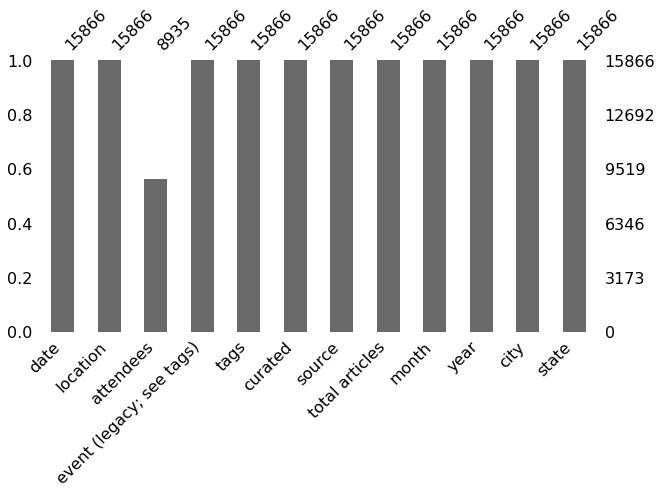

In [255]:
msno.bar(attendees, figsize=(10,5));

* The 'attendees' column is only ~60% complete
* Drop event (legacy)

## Distributions

### Number of events by month (Attendee Dataset)

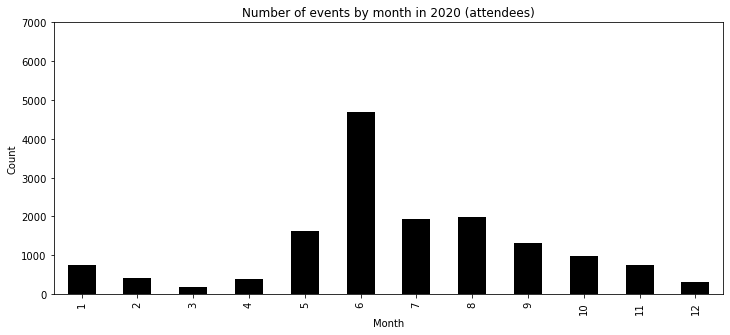

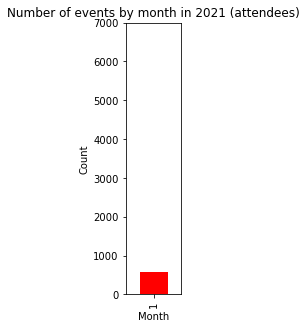

In [256]:
plt.figure(figsize=(12,5))
attendees[attendees['year']!=2021].groupby(attendees["date"].dt.month)['date'].count().plot(kind="bar",color='black')
plt.title('Number of events by month in 2020 (attendees)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 7000])
plt.show()

plt.figure(figsize=(1,5))
attendees[attendees['year']==2021].groupby(attendees["date"].dt.month)['date'].count().plot(kind="bar",color='red')
plt.title('Number of events by month in 2021 (attendees)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.ylim([0, 7000])
plt.show()

### By State (Attendee Dataset)

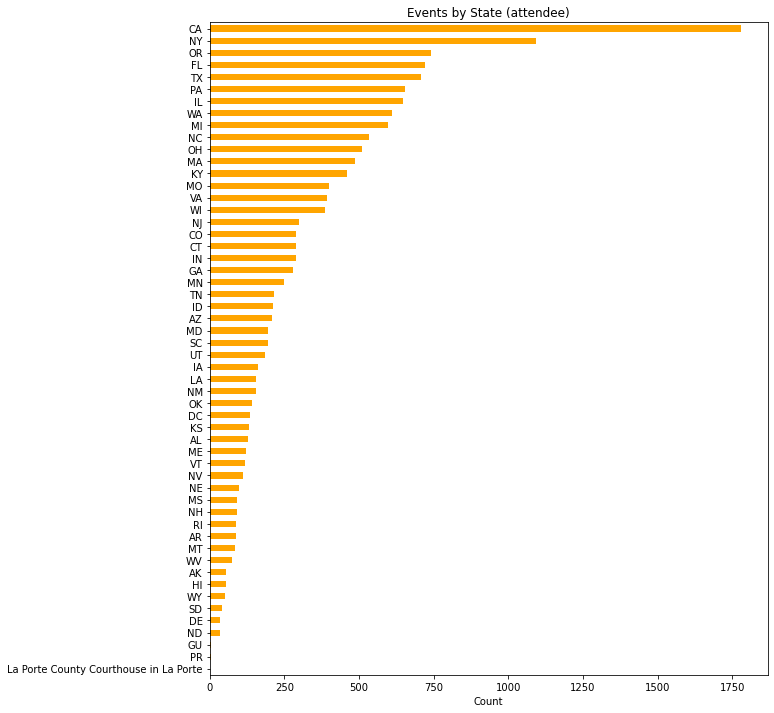

In [257]:
plt.figure(figsize=(10,12))
attendees['state'].value_counts().sort_values().plot(kind='barh', color='orange')
plt.xlabel('Count')
plt.title("Events by State (attendee)")
plt.show()

There may be more events in Oregon in this dataset compared to the ACLED dataset.

## Check for correlation between event counts in protest vs attendees dataset

In [258]:
attendees.describe()

,attendees,total articles,month,year
count,8935.000000,15866.000000,15866.000000,15866.000000
mean,284.911136,3.441006,6.500693,2020.036871
std,1679.665817,14.543650,2.605825,0.188452
min,0.000000,1.000000,1.000000,2020.000000
25%,30.000000,1.000000,6.000000,2020.000000
50%,100.000000,1.000000,6.000000,2020.000000
75%,200.000000,2.000000,8.000000,2020.000000
max,100000.000000,1368.000000,12.000000,2021.000000


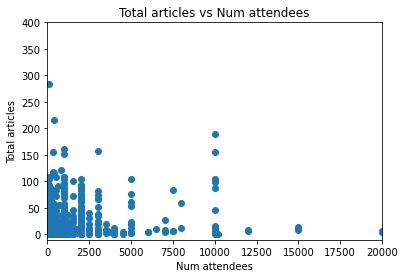

In [259]:
# check to see if there is a correlation between number of attendees at an event and number of articles about the event

attendees.rename(columns={'total articles':'total_articles'}, inplace=True)
plt.scatter(attendees['attendees'], attendees['total_articles'])
plt.title('Total articles vs Num attendees')
plt.xlabel('Num attendees')
plt.ylabel('Total articles')
plt.xlim([-10, 20000])
plt.ylim([-10, 400])
plt.show()

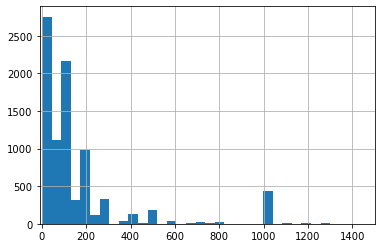

In [260]:
# check to see what the distribution of number of attendees is
attendees[attendees['attendees']<1500]['attendees'].hist(bins=30)
plt.xlim([-10, 1500])
plt.show()

In [261]:
attendees['attendees'].describe()

count      8935.000000
mean        284.911136
std        1679.665817
min           0.000000
25%          30.000000
50%         100.000000
75%         200.000000
max      100000.000000
Name: attendees, dtype: float64

There is a huge distribution of attendees at these protests. Mostly in the few hundreds. But the largest supposedly had 100,000 people attend. Check it out.

In [262]:
attendees.sort_values(by='attendees', ascending=False).head(10)

,date,location,attendees,event (legacy; see tags),tags,curated,source,total_articles,month,year,city,state
22705,2020-01-20,"Pittman-Sullivan Park, San Antonio, TX",100000.0,Racial Injustice,"Civil Rights; For racial justice; Martin Luther King, Jr.",Yes,https://www.mysanantonio.com/news/local/article/Martin-Luther-King-Jr-narch-in-San-Antonio-2020-14990119.php,5,1,2020,San Antonio,TX
27011,2020-06-05,"Houston, TX",60000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,http://www.salamancapress.com/houston-hip-hop-artists-organize-massive-protest/video_678e6797-dc24-5609-90f2-08ede6269758.html,2,6,2020,Houston,TX
28849,2020-06-12,"Seattle, WA",60000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.seattletimes.com/seattle-news/seattle-area-protests-live-updates-on-friday-june-12/,11,6,2020,Seattle,WA
35813,2020-10-11,"Beverly Hills, CA",35000.0,International Relations,International; Against war; Armenia,No,https://www.latimes.com/california/story/2020-10-11/armenian-protest-turkish-consulate,6,10,2020,Beverly Hills,CA
22321,2020-01-05,"Cadman Plaza, Brooklyn, NY",25000.0,Civil Rights,Civil Rights; For religious tolerance,Yes,https://www.pix11.com/news/local-news/manhattan/watch-live-thousands-march-brooklyn-bridge-support-jewish-community-no-hate-no-fear-march-solidarity,46,1,2020,Brooklyn,NY
25982,2020-06-02,"Houston, TX",25000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.washingtonpost.com/local/new-fencing-encircles-white-house-continued-federal-forces-on-day-5-of-dc-protests/2020/06/02/d323e112-a4e8-11ea-b473-04905b1af82b_story.html,34,6,2020,Houston,TX
22690,2020-01-20,"State Capitol, Richmond, VA",22000.0,Guns,Guns; Against greater gun control,No,https://apnews.com/2c997c92fa7acd394f7cbb89882d9b5b,424,1,2020,Richmond,VA
27464,2020-06-06,"Union Park, Chicago, IL",20000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.chicagotribune.com/news/breaking/ct-george-floyd-chicago-protests-20200606-ee4mdvafvbfhfcpr7lrzfayypu-story.html,5,6,2020,Chicago,IL
27999,2020-06-07,"Hollywood, Los Angeles, CA",20000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.latimes.com/california/story/2020-06-08/massive-hollywood-protest-george-floyd-movement,7,6,2020,Los Angeles,CA
25677,2020-06-01,"Oakland, CA",15000.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.sfchronicle.com/bayarea/article/Crowds-gather-in-Oakland-San-Francisco-other-15309638.php,14,6,2020,Oakland,CA


In [263]:
attendees[attendees['attendees']==25000]['source']

22321                                  https://www.pix11.com/news/local-news/manhattan/watch-live-thousands-march-brooklyn-bridge-support-jewish-community-no-hate-no-fear-march-solidarity
25982    https://www.washingtonpost.com/local/new-fencing-encircles-white-house-continued-federal-forces-on-day-5-of-dc-protests/2020/06/02/d323e112-a4e8-11ea-b473-04905b1af82b_story.html
Name: source, dtype: object

Notes:
* 1/20/2020 - San Antonio, TX: Source link error. No hits with Google. Not present in new_protest dataset. This is probably in error
* 6/5/2020 - Houston, TX: Source link error. Google hit: BLM protest. Present in new_protest dataset
* 6/12/2020 - Seattle, WA: Source link error. Google hit: BLM protest. Present in new_protest dataset. new_protest has seattle-CHOP and seattle. Needs to be reconciled
* 10/11/2020 - Beverly Hills, CA: Source link error. Google hit: Armenian support protest. Present in new_protest dataset
* 01/05/2020 - Brooklyn, NY: Source link error. Present in new_protest dataset. Should be Manhattan, NY, not Brooklyn

In [264]:
attendees[attendees['city'].str.contains('Dover')] # check for uniqueness

,date,location,attendees,event (legacy; see tags),tags,curated,source,total_articles,month,year,city,state
22536,2020-01-14,"State Capitol, Dover, DE",NaN,Collective Bargaining,Collective Bargaining; For higher minimum wage,Yes,https://www.delawareonline.com/story/news/local/2020/01/15/cleaners-union-rallies-dover-statewide-15-minimum-hourly-wage/4475918002/,1,1,2020,Dover,DE
23642,2020-04-11,"Dover, NH",50.0,Immigration,Immigration; For compassionate immigration; Coronavirus,Yes,https://www.fosters.com/news/20200412/car-rally-urges-dover-jail-to-release-immigrant-detainees,2,4,2020,Dover,NH
23653,2020-04-12,"Dover, NH",30.0,Immigration,Immigration; For compassionate immigration; Coronavirus,Yes,https://www.fosters.com/news/20200424/third-rally-to-urge-release-of-immigrants-from-strafford-county-jail-to-slow-spread-of-covid-19,1,4,2020,Dover,NH
23775,2020-04-19,"Dover, NH",60.0,Immigration,Immigration; For compassionate immigration; Coronavirus,Yes,https://www.fosters.com/news/20200424/third-rally-to-urge-release-of-immigrants-from-strafford-county-jail-to-slow-spread-of-covid-19,1,4,2020,Dover,NH
24044,2020-05-01,"State Capitol, Dover, DE",100.0,Healthcare,Healthcare; Against pandemic intervention; Coronavirus,No,https://www.delawareonline.com/story/news/politics/2020/05/08/delaware-anti-quarantine-protesters-plan-rehoboth-beach-rally/5179098002/,3,5,2020,Dover,DE
24140,2020-05-03,"Dover, NH",65.0,Immigration,Immigration; For compassionate immigration; Coronavirus,Yes,https://manchesterinklink.com/protesters-say-ice-have-a-heart-in-car-rally-to-free-immigrants-at-strafford-county-jail/,2,5,2020,Dover,NH
24196,2020-05-08,"State Capitol, Dover, DE",100.0,Healthcare,Healthcare; Against pandemic intervention; Coronavirus,No,https://www.delawareonline.com/story/news/politics/2020/05/08/delaware-anti-quarantine-protesters-plan-rehoboth-beach-rally/5179098002/,1,5,2020,Dover,DE
24251,2020-05-10,"Dover, NH",100.0,Immigration,Immigration; For compassionate immigration; Coronavirus,Yes,https://manchesterinklink.com/car-rallies-give-hope-and-support-to-detainees/,1,5,2020,Dover,NH
25301,2020-05-31,"Dover, OH",NaN,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.timesreporter.com/news/20200531/peaceful-protest-george-floyd-protest-draws-hundreds-to-downtown-new-philadelphia,1,5,2020,Dover,OH
25594,2020-05-31,"Dover, DE",200.0,Racial Injustice,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.capegazette.com/article/photojournalist-recounts-protest-used-front-rioting/209011,1,5,2020,Dover,DE


### Create unique ID

In [265]:
attendees['state'].iloc[0]

'AZ'

In [266]:
# convert city, state, to lowercase snakecase

attendees['state'] = attendees['state'].str.strip()

attendees['city'] = attendees['city'].str.lower().str.strip()
attendees['city'].replace(' ','_', regex=True, inplace=True)

attendees['state'] = attendees['state'].str.lower()

# Create unique ID for each event
attendees['id'] = attendees['date'].astype(str) + '_' + attendees['city'] + '_' + attendees['state']

In [267]:
attendees.head()

,date,location,attendees,event (legacy; see tags),tags,curated,source,total_articles,month,year,city,state,id
22231,2020-01-01,"Phoenix, AZ",NaN,Other,Other; For greater safety; Transportation,No,https://www.12news.com/article/news/local/valley/red-light-camera-protest/75-7d006d53-459f-4f94-8da9-c624f275fbfc,1,1,2020,phoenix,az,2020-01-01_phoenix_az
22232,2020-01-02,"Cleveland, OH",NaN,Other,Other; For greater safety; Transportation,No,https://fox8.com/2020/01/02/community-members-hold-protest-candlelight-vigil-after-36-year-old-mother-struck-killed-while-crossing-east-cleveland-road/,1,1,2020,cleveland,oh,2020-01-02_cleveland_oh
22233,2020-01-02,"Harvard, MA",30.0,Environment,Environment; Against fossil fuels,Yes,https://www.bostonglobe.com/2020/01/03/metro/four-arrested-after-climate-activists-block-railroad-tracks-with-scaffold-town-harvard/,6,1,2020,harvard,ma,2020-01-02_harvard_ma
22234,2020-01-02,"City Hall, Scarborough, ME",20.0,Collective Bargaining,Collective Bargaining; For better compensation,No,https://mainebeacon.com/scarborough-teachers-rally-for-more-rights-better-pay/,1,1,2020,scarborough,me,2020-01-02_scarborough_me
22235,2020-01-02,"Grand Junction, CO",20.0,Executive,Executive; Against cabinet member; For firing/reassignment,Yes,https://sentinelcolorado.com/news/state-and-region/demonstrators-protest-blm-leaders-at-new-grand-junction-location/,4,1,2020,grand_junction,co,2020-01-02_grand_junction_co


### Reorganize attendees df so it's easy to look at

In [268]:
# reorganize attendees df
col_attendees = ['id','date','month','year','city','state','attendees','tags','curated','source','total_articles']
attendees = attendees[col_attendees]
attendees.reset_index(inplace=True)
attendees.drop(columns='index', inplace=True)
attendees.head(3)

,id,date,month,year,city,state,attendees,tags,curated,source,total_articles
0,2020-01-01_phoenix_az,2020-01-01,1,2020,phoenix,az,NaN,Other; For greater safety; Transportation,No,https://www.12news.com/article/news/local/valley/red-light-camera-protest/75-7d006d53-459f-4f94-8da9-c624f275fbfc,1
1,2020-01-02_cleveland_oh,2020-01-02,1,2020,cleveland,oh,NaN,Other; For greater safety; Transportation,No,https://fox8.com/2020/01/02/community-members-hold-protest-candlelight-vigil-after-36-year-old-mother-struck-killed-while-crossing-east-cleveland-road/,1
2,2020-01-02_harvard_ma,2020-01-02,1,2020,harvard,ma,30.0,Environment; Against fossil fuels,Yes,https://www.bostonglobe.com/2020/01/03/metro/four-arrested-after-climate-activists-block-railroad-tracks-with-scaffold-town-harvard/,6


# Population Dataset

We want to also have population information for each protest location. We use data from [Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L2GSK6), though it's from 2015.

In [269]:
cities = pd.read_csv('../Data/BLM_cities.csv')
cities.drop(columns='Unnamed: 0',inplace=True)
cities.shape

(1359, 51)

In [270]:
cities.head(3)

,FIPS,Geography.x,TotalPop,PovertyRate,BlackPop,BlackPovertyRate,AsianPop,AsianPoverty,HispanicPop,HispanicPoverty,WhitePop,WhitePovertyRate,PercentBachelor.s,State..FIPS.,Place..FIPS.,Area.Name,SqMiles,tot.protests,tot.attend,deaths,deaths_unarmed,deaths_unarmed_black,deaths_armed_black,deaths_black,deaths_protestyear,deaths_protestyear_unarmed,X.x,NAACPyears,MayorPartisanship,blackmayor,FIPS_PLACE,dem,rep,dem_share,FIPS_ST,X.y,pop,hbcu,hbcu2,crime,deathduring,per_ba,Per_Black,pop.density,collegeenrollpc,mayorrep,unarmed_deaths_pc,deaths_pc,unarmed_deaths_black_pc,deaths_black_pc,anyprotests
0,100820,"Alabaster city, Alabama",30613,11.1,4061,11.6,124,0.0,3524,47.9,22381,5.4,33.992558,1.0,820.0,Alabaster,23.400,0,0,0,0,0,0,0,0,0,NaN,0,R,0.0,820.0,3431.0,9814.0,25.90411,1.0,NaN,0,0,0,0,0,33.992558,13.265606,1308.247863,0.000000,1,0.0,0.0,0.0,0.0,0
1,1021200,"Dover city, Delaware",32475,19.0,13058,24.5,781,22.2,2898,22.6,14949,12.1,29.008288,10.0,21200.0,Dover,23.148,0,0,0,0,0,0,0,1,1,162.0,4,D,0.0,21200.0,9741.0,5243.0,65.00934,10.0,307.0,5000,1,1,0,1,29.008288,40.209392,1402.928979,15.396459,0,0.0,0.0,0.0,0.0,0
2,103076,"Auburn city, Alabama",52721,31.3,9355,38.6,3569,21.3,2114,25.9,36983,30.8,60.245466,1.0,3076.0,Auburn,56.807,0,0,0,0,0,0,0,0,0,NaN,0,R,0.0,3076.0,8617.0,12129.0,41.53572,1.0,3.0,30000,0,0,0,0,60.245466,17.744352,928.072245,56.903321,1,0.0,0.0,0.0,0.0,0


In [271]:
# drop some columns
col_cities = ['Geography.x', 'TotalPop', 'PovertyRate', 'BlackPop',
       'BlackPovertyRate', 'AsianPop', 'AsianPoverty', 'HispanicPop',
       'HispanicPoverty', 'WhitePop', 'WhitePovertyRate', 'PercentBachelor.s',
       'Area.Name', 'SqMiles', 'deaths', 'deaths_unarmed', 'deaths_unarmed_black',
       'deaths_armed_black', 'deaths_black', 'deaths_protestyear',
       'deaths_protestyear_unarmed', 'NAACPyears', 'MayorPartisanship',
       'blackmayor', 'dem', 'rep', 'dem_share', 
       'pop', 'hbcu', 'hbcu2', 'crime', 'deathduring', 'per_ba', 'Per_Black',
       'pop.density', 'collegeenrollpc', 'mayorrep', 'unarmed_deaths_pc',
       'deaths_pc', 'unarmed_deaths_black_pc', 'deaths_black_pc']
cities = cities[col_cities]

In [272]:
cities.columns = cities.columns.str.lower()
cities.columns

Index(['geography.x', 'totalpop', 'povertyrate', 'blackpop',
       'blackpovertyrate', 'asianpop', 'asianpoverty', 'hispanicpop',
       'hispanicpoverty', 'whitepop', 'whitepovertyrate', 'percentbachelor.s',
       'area.name', 'sqmiles', 'deaths', 'deaths_unarmed',
       'deaths_unarmed_black', 'deaths_armed_black', 'deaths_black',
       'deaths_protestyear', 'deaths_protestyear_unarmed', 'naacpyears',
       'mayorpartisanship', 'blackmayor', 'dem', 'rep', 'dem_share', 'pop',
       'hbcu', 'hbcu2', 'crime', 'deathduring', 'per_ba', 'per_black',
       'pop.density', 'collegeenrollpc', 'mayorrep', 'unarmed_deaths_pc',
       'deaths_pc', 'unarmed_deaths_black_pc', 'deaths_black_pc'],
      dtype='object')

In [273]:
col_dict = {'geography.x':'geography', 'percentbachelor.s':'percentbachelor',
       'area.name':'area_name', 'pop.density':'pop_density', 'area.name':'city'}
cities.rename(col_dict, axis=1, inplace=True)

In [274]:
# extract 'state' from 'geography'
cities['state'] = cities['geography'].apply(split_state)

# abbreviated states
cities['state'] = cities['state'].apply(abbrev_states)

# 'city': lowercase, snakecase
cities['city'] = cities['city'].str.lower()
cities['city'].replace(' ','_', regex=True, inplace=True)

# 'state': lowercase
cities['state'] = cities['state'].str.lower()

# Create unique ID for each event (for merging with protest dataset)
cities['city_state'] = cities['city'] + '_' + cities['state']

In [275]:
cities.head(3)

,geography,totalpop,povertyrate,blackpop,blackpovertyrate,asianpop,asianpoverty,hispanicpop,hispanicpoverty,whitepop,whitepovertyrate,percentbachelor,city,sqmiles,deaths,deaths_unarmed,deaths_unarmed_black,deaths_armed_black,deaths_black,deaths_protestyear,deaths_protestyear_unarmed,naacpyears,mayorpartisanship,blackmayor,dem,rep,dem_share,pop,hbcu,hbcu2,crime,deathduring,per_ba,per_black,pop_density,collegeenrollpc,mayorrep,unarmed_deaths_pc,deaths_pc,unarmed_deaths_black_pc,deaths_black_pc,state,city_state
0,"Alabaster city, Alabama",30613,11.1,4061,11.6,124,0.0,3524,47.9,22381,5.4,33.992558,alabaster,23.400,0,0,0,0,0,0,0,0,R,0.0,3431.0,9814.0,25.90411,0,0,0,0,0,33.992558,13.265606,1308.247863,0.000000,1,0.0,0.0,0.0,0.0,al,alabaster_al
1,"Dover city, Delaware",32475,19.0,13058,24.5,781,22.2,2898,22.6,14949,12.1,29.008288,dover,23.148,0,0,0,0,0,1,1,4,D,0.0,9741.0,5243.0,65.00934,5000,1,1,0,1,29.008288,40.209392,1402.928979,15.396459,0,0.0,0.0,0.0,0.0,de,dover_de
2,"Auburn city, Alabama",52721,31.3,9355,38.6,3569,21.3,2114,25.9,36983,30.8,60.245466,auburn,56.807,0,0,0,0,0,0,0,0,R,0.0,8617.0,12129.0,41.53572,30000,0,0,0,0,60.245466,17.744352,928.072245,56.903321,1,0.0,0.0,0.0,0.0,al,auburn_al


# Police Brutality Dataset

We would like to merge the ACLED dataset with a different police brutality dataset.

In [276]:
police = pd.read_csv('../Data/dataworld_policebrutality.csv')
police.shape

(1301, 52)

In [277]:
police.head(3)

,state,edit_at,city,name,date,date_text,id,Link 1,Link 2,Link 3,Link 4,Link 5,Link 6,Link 7,Link 8,Link 9,Link 10,Link 11,Link 12,Link 13,Link 14,Link 15,Link 16,Link 17,Link 18,Link 19,Link 20,Link 21,Link 22,Link 23,Link 24,Link 25,Link 26,Link 27,Link 28,Link 29,Link 30,Link 31,Link 32,Link 33,Link 34,Link 35,Link 36,Link 37,Link 38,Link 39,Link 40,Link 41,Link 42,Link 43,Link 44,Link 45
0,Iowa,https://github.com/2020PB/police-brutality/blob/main/reports/Iowa.md,Des Moines,"Police repeatedly shoot tear gas into crowd, even after crowd has dispersed",2020-05-29,2020-05-29,ia-desmoines-2,https://www.kcci.com/article/developing-protesters-face-off-with-police-in-downtown-des-moines/32717301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Iowa,https://github.com/2020PB/police-brutality/blob/main/reports/Iowa.md,Des Moines,"Police truck shoots at cars, hitting mother and breaking her finger",2020-05-30,2020-05-30,ia-desmoines-3,https://www.reddit.com/r/2020PoliceBrutality/comments/gxlfdo/police_truck_shoots_at_cars_hitting_mother_and/?utm_source=share&utm_medium=web2x,https://www.tiktok.com/@jakegracey/video/6834936818799004934?source=h5_m,"https://www.google.ca/maps/@41.6293563,-93.6988361,3a,75y,358.27h,68.85t/data=!3m6!1e1!3m4!1s5NdIPPqrW0kAv0Ge9xX4EQ!2e0!7i16384!8i8192",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Iowa,https://github.com/2020PB/police-brutality/blob/main/reports/Iowa.md,Des Moines,"Police tear gas, pepper spray and beat peaceful protesters",2020-05-30,2020-05-30,ia-desmoines-11,https://www.facebook.com/andre.develliott.9/videos/260083008434875/,https://www.reddit.com/r/desmoines/comments/gxkoii/some_additional_footage_from_saturday_night/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
police['state'].value_counts(dropna=False)

Oregon              424
New York            134
California          111
Washington           81
Washington DC        53
Ohio                 40
Minnesota            36
Texas                34
Colorado             33
Illinois             31
Pennsylvania         30
Kentucky             29
Virginia             27
North Carolina       26
Florida              26
Wisconsin            21
Michigan             21
Massachusetts        17
Georgia              14
Missouri             14
Iowa                 13
Indiana              10
Tennessee             9
Arizona               9
Alabama               8
Nebraska              7
Utah                  7
Nevada                6
Oklahoma              4
Connecticut           4
Rhode Island          4
Arkansas              3
South Carolina        3
Delaware              2
North Dakota          2
Louisiana             1
South Dakota          1
Wyoming               1
Unknown Location      1
Vermont               1
Kansas                1
New Mexico      

Police brutality dataset only has 1301 events even though it starts in 2020 and goes to March 2021 (same timeframe as the ACLED dataset) whereas the ACLED dataset has 25607 events. It is not practical to merge the datasets. Additionally, the ACLED dataset already has information on force used by police. Just use this dataset along with CountVectorizer in order to extract information.

# Merging Datasets

In [279]:
# merge protest with attendees
new_df1 = pd.merge(protest, attendees,  how='left', left_on=['id'], right_on = ['id'])

# and then merge with cities
new_df2 = pd.merge(new_df1, cities,  how='left', left_on=['city_state'], right_on = ['city_state'])

In [280]:
new_df2.columns

Index(['id', 'date_x', 'month_x', 'year_x', 'city_x', 'state_x', 'city_state',
       'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'type_actor1', 'actor2', 'assoc_actor_2',
       'type_actor2', 'interaction', 'notes', 'fatalities', 'county',
       'latitude', 'longitude', 'geo_precision', 'source_x', 'source_scale',
       'date_y', 'month_y', 'year_y', 'city_y', 'state_y', 'attendees', 'tags',
       'curated', 'source_y', 'total_articles', 'geography', 'totalpop',
       'povertyrate', 'blackpop', 'blackpovertyrate', 'asianpop',
       'asianpoverty', 'hispanicpop', 'hispanicpoverty', 'whitepop',
       'whitepovertyrate', 'percentbachelor', 'city', 'sqmiles', 'deaths',
       'deaths_unarmed', 'deaths_unarmed_black', 'deaths_armed_black',
       'deaths_black', 'deaths_protestyear', 'deaths_protestyear_unarmed',
       'naacpyears', 'mayorpartisanship', 'blackmayor', 'dem', 'rep',
       'dem_share', 'pop', 'hbcu', 'hbcu2', 'crime', 'deathdur

In [281]:
col_integrate = ['id', 'date_x', 'month_x', 'year_x', 'city_x', 'state_x',
       'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'type_actor1', 'actor2', 'assoc_actor_2',
       'type_actor2', 'interaction', 'notes', 'fatalities', 'county',
       'latitude', 'longitude', 'geo_precision', 'source_x', 'source_scale',
       'attendees', 'tags',
       'curated', 'source_y', 'total_articles', 'totalpop',
       'povertyrate', 'blackpop', 'blackpovertyrate', 'asianpop',
       'asianpoverty', 'hispanicpop', 'hispanicpoverty', 'whitepop',
       'whitepovertyrate', 'percentbachelor', 'sqmiles', 'deaths',
       'deaths_unarmed', 'deaths_unarmed_black', 'deaths_armed_black',
       'deaths_black', 'deaths_protestyear', 'deaths_protestyear_unarmed',
       'naacpyears', 'mayorpartisanship', 'blackmayor', 'dem', 'rep',
       'dem_share', 'pop', 'hbcu', 'hbcu2', 'crime', 'deathduring', 'per_ba',
       'per_black', 'pop_density', 'collegeenrollpc', 'mayorrep',
       'unarmed_deaths_pc', 'deaths_pc', 'unarmed_deaths_black_pc',
       'deaths_black_pc']
integrate = new_df2[col_integrate]

In [282]:
integrate_dict = {'date_x':'date', 'month_x':'month', 'year_x':'year', 'city_x':'city', 'state_x':'state'}

In [283]:
integrate.rename(integrate_dict, axis=1, inplace=True)

/Users/aida/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [284]:
def count_protestors(note):
    if 'several' in note:
        return 5
    if 'size=small' in note:
        return 5
    elif 'dozen' in note:
        return 24
    elif 'hundred' in note:
        return 200
    elif 'thousand' in note:
        return 2000
    elif len(re.split(' |]|-|=',note)) > 2:
        try:
            return int(re.split(' |]|-|=',note)[-2].replace(',', ''))
        except:
            pass

In [285]:
integrate['acled_count'] = integrate['notes'].apply(count_protestors)

<ipython-input-285-c5c9ce1862c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  integrate['acled_count'] = integrate['notes'].apply(count_protestors)


In [286]:
# replace 'attendees' with max of either 'acled_count' or 'attendees'
integrate['attendees'] = integrate[['acled_count','attendees']].max(axis=1)
integrate.drop(columns='acled_count',inplace=True)
integrate['attendees'].value_counts(dropna=False)

<ipython-input-286-184d927219aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  integrate['attendees'] = integrate[['acled_count','attendees']].max(axis=1)
/Users/aida/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


NaN       11372
200.0      3212
24.0       2372
100.0      2248
50.0        989
          ...  
217.0         1
6700.0        1
117.0         1
9500.0        1
122.0         1
Name: attendees, Length: 158, dtype: int64

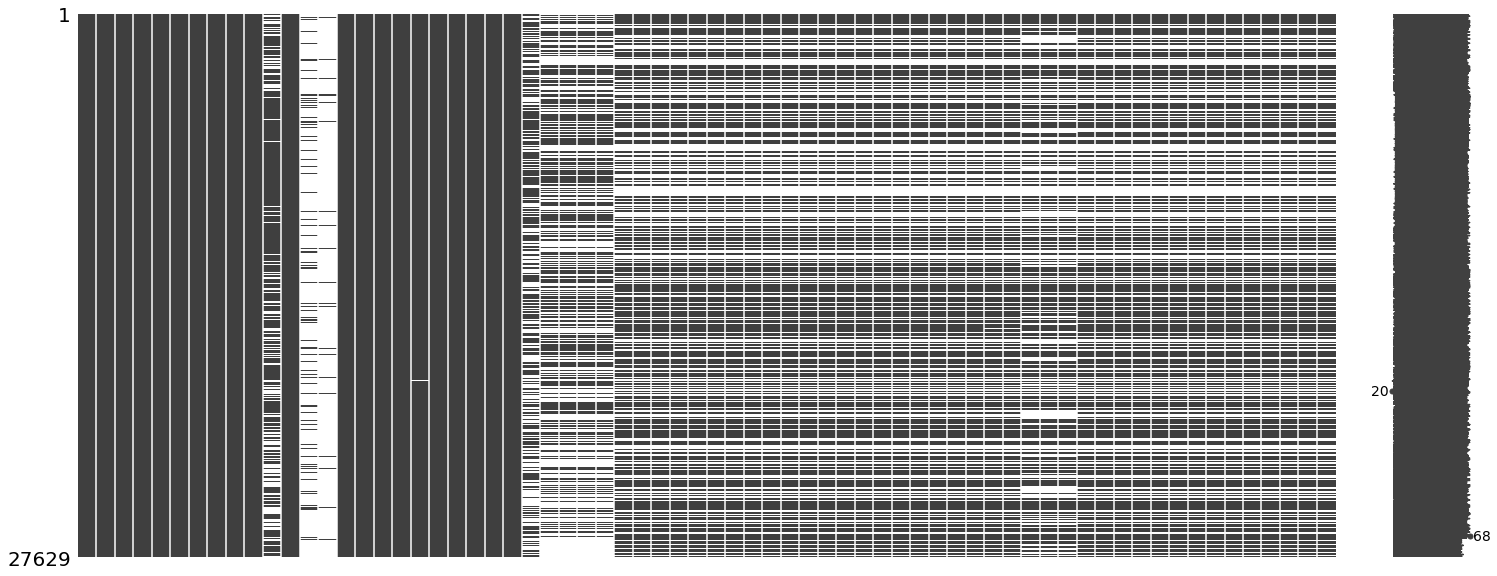

In [287]:
# for some reason msno.bar throws an error
msno.matrix(integrate)
plt.show()

In [288]:
# export integrated dataset for further analysis
integrate.to_csv('../Data/integrated_protest.csv',index=False)

In [289]:
integrate.columns

Index(['id', 'date', 'month', 'year', 'city', 'state', 'time_precision',
       'event_type', 'sub_event_type', 'actor1', 'assoc_actor_1',
       'type_actor1', 'actor2', 'assoc_actor_2', 'type_actor2', 'interaction',
       'notes', 'fatalities', 'county', 'latitude', 'longitude',
       'geo_precision', 'source_x', 'source_scale', 'attendees', 'tags',
       'curated', 'source_y', 'total_articles', 'totalpop', 'povertyrate',
       'blackpop', 'blackpovertyrate', 'asianpop', 'asianpoverty',
       'hispanicpop', 'hispanicpoverty', 'whitepop', 'whitepovertyrate',
       'percentbachelor', 'sqmiles', 'deaths', 'deaths_unarmed',
       'deaths_unarmed_black', 'deaths_armed_black', 'deaths_black',
       'deaths_protestyear', 'deaths_protestyear_unarmed', 'naacpyears',
       'mayorpartisanship', 'blackmayor', 'dem', 'rep', 'dem_share', 'pop',
       'hbcu', 'hbcu2', 'crime', 'deathduring', 'per_ba', 'per_black',
       'pop_density', 'collegeenrollpc', 'mayorrep', 'unarmed_deaths_pc',
 

In [304]:
# check protest types for 1 date
integrate[integrate['date']=='2020-06-12'][['sub_event_type']].value_counts().sort_values(ascending=False)

sub_event_type                    
Peaceful protest                      208
Other                                   2
Protest with intervention               2
Violent demonstration                   2
Attack                                  1
Excessive force against protesters      1
dtype: int64

In [305]:
# check overall count of event types
integrate['sub_event_type'].value_counts(dropna=False).sort_values(ascending=False)

Peaceful protest                      24261
Violent demonstration                  1000
Protest with intervention               966
Other                                   681
Change to group/activity                360
Excessive force against protesters      127
Attack                                  105
Mob violence                             48
Arrests                                  32
Looting/property destruction             22
Disrupted weapons use                    12
Armed clash                              10
Sexual violence                           2
Remote explosive/landmine/IED             1
Suicide bomb                              1
Grenade                                   1
Name: sub_event_type, dtype: int64

In [303]:
integrate.sort_values(by='attendees', ascending=False).iloc[:5].head(3)

,id,date,month,year,city,state,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,notes,fatalities,county,latitude,longitude,geo_precision,source_x,source_scale,attendees,tags,curated,source_y,total_articles,totalpop,povertyrate,blackpop,blackpovertyrate,asianpop,asianpoverty,hispanicpop,hispanicpoverty,whitepop,whitepovertyrate,percentbachelor,sqmiles,deaths,deaths_unarmed,deaths_unarmed_black,deaths_armed_black,deaths_black,deaths_protestyear,deaths_protestyear_unarmed,naacpyears,mayorpartisanship,blackmayor,dem,rep,dem_share,pop,hbcu,hbcu2,crime,deathduring,per_ba,per_black,pop_density,collegeenrollpc,mayorrep,unarmed_deaths_pc,deaths_pc,unarmed_deaths_black_pc,deaths_black_pc
8477,2020-06-06_washington_dc_dc,2020-06-06,6,2020,washington_dc,dc,1,Protests,Protest with intervention,Protesters (United States),BLM: Black Lives Matter,6,Police Forces of the United States (2017-2021),NaN,1,16,"On 6 June 2020, between 100000 to 200000 people staged a protest in DC (District of Columbia) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. 1 person was arrested. [size=between 100000 to 200000]",0,district_of_columbia,38.9171,-77.0003,1,WTRF7,National,200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8537,2020-06-06_philadelphia_pa,2020-06-06,6,2020,philadelphia,pa,1,Protests,Peaceful protest,Protesters (United States),BLM: Black Lives Matter,6,NaN,NaN,0,60,"On 6 June 2020, between 50,000 and 80,000 people staged a protest in Philadelphia (Pennsylvania) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=between 50,000 and 80,000]",0,philadelphia,39.9525,-75.1636,1,New York Times; NBC News,National,80000.0,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://6abc.com/police-brutality-racism-in-america-george-floyd-protest-philly-art-museum/6234637/,41.0,1503859.0,26.7,653313.0,31.3,98918.0,28.7,197851.0,42.1,538409.0,15.4,24.726549,134.027,13.0,1.0,0.0,4.0,4.0,4.0,0.0,16.0,D,1.0,595231.0,117105.0,83.56043,130000.0,0.0,0.0,1.0,0.0,24.726549,43.442437,11220.567498,8.644427,0.0,0.006650,0.086444,0.000000,0.026598
6107,2020-06-02_houston_tx,2020-06-02,6,2020,houston,tx,1,Riots,Violent demonstration,Rioters (United States),BLM: Black Lives Matter; Civilians (United States); Journalists (United States),5,Police Forces of the United States (2017-2021),NaN,1,15,"On 2 June 2020, in Houston (Texas), a group of rioters clashed with the police following a protest in support of the Black Lives Matter movement, attended by approximately 60,000 people. At least 200 people were arrested, including a journalist. [size=approximately 60,000]",0,harris,29.7603,-95.3644,1,Committee to Protect Journalists; US Press Freedom Tracker; Reno Gazette Journal,Other-National,60000.0,Civil Rights; For racial justice; For greater accountability; Police,Yes,https://www.washingtonpost.com/local/new-fencing-encircles-white-house-continued-federal-forces-on-day-5-of-dc-protests/2020/06/02/d323e112-a4e8-11ea-b473-04905b1af82b_story.html,34.0,2136523.0,22.9,493701.0,28.2,134269.0,17.3,942583.0,29.2,544355.0,9.0,29.997063,598.369,21.0,3.0,2.0,10.0,12.0,12.0,2.0,13.0,D,1.0,364111.6,225330.4,61.77225,85000.0,1.0,1.0,1.0,1.0,29.997063,23.107685,3570.577687,3.978427,0.0,0.014042,0.098291,0.009361,0.056166


# Check for missing integration output

In [293]:
# rows with > 10 null columns
lots_nulls = integrate[integrate.isnull().sum(axis=1)>10]
lots_nulls.shape

(10151, 68)

In [298]:
integrate[integrate['date']=='2020-06-12'][['sub_event_type','notes','attendees']][10:20]

,sub_event_type,notes,attendees
10089,Peaceful protest,"On 12 June 2020, about 50 protesters gathered in Orange Park (Clay, Florida) to call for an end to police brutality, racism and injustice in the wake of George Floyd's death. Protesters held signs and chanted. [size=about 50]",50.0
10090,Excessive force against protesters,"On 12 June 2020, about 150 immigrants held at the Adelanto ICE Processing Facility in Adelanto (California) protested against lockdown measures amid the coronavirus pandemic. ICE authorities dispersed the protesters using tear gas, pepper spray, and rubber bullets. Four detainees were injured and required medical attention at an off-site medical facility. [size=about 150]",150.0
10091,Peaceful protest,"On 12 June 2020, thousands of protesters staged six protests in New York-Manhattan District (New York, New York) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. One of the protest was billed as the Black Women's empowerment March and hundreds of people participated. [size=thousands]",200.0
10092,Peaceful protest,"On 12 June 2020, thousands of protesters staged 11 protests in New York-Brooklyn District (Kings, New York) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=thousands]",2000.0
10093,Peaceful protest,"On 12 June 2020, protesters staged three protests in New York-Bronx District (Bronx, New York) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=no report]",NaN
10094,Protest with intervention,"On 12 June 2020, at least 150 immigrant detainees staged a protest at Adelanto Detention Center in Adelanto (California) against prison conditions amid the coronavirus pandemic. Guards wearing SWAT-like gear broke up the protest using pepper bullets and pepper spray. At least 4 detainees required treatment at an off-site medical facility, although the extent of their injuries is unclear. [size=at least 150]",150.0
10095,Peaceful protest,"On 12 June 2020, people staged a protest in Mount Hope (West Virginia) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=no report]",NaN
10096,Peaceful protest,"On 12 June 2020, dozens of people protested and marched in downtown Miami (Miami-Dade, Florida) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. They marched onto highway I-95 and had a standoff with the law enforcement. No clash was reported. [size=dozens]",200.0
10097,Peaceful protest,"On 12 June 2020, an unknown number of people protested in downtown Memphis (Shelby, Tennessee) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=no report]",30.0
10098,Peaceful protest,"On 12 June 2020, hundreds of people staged a protest in Louisville (Kentucky) in support of the Black Lives Matter movement and against police brutality and the deaths of Breonna Taylor and George Floyd. This took place after a historic Thursday where Breonna's Law was passed, banning the Louisville police from using no-knock warrants. [size=hundreds]",200.0


In [300]:
# confirm 'attendees' null probably has no other missing info
integrate[integrate['attendees'].isnull()]['notes'][:5]

0                                                                                                          On 1 January 2020, an unknown number of people associated with the Cleveland Association of Rescue Employees demonstrated at the City Hall in Cleveland (Ohio) to demand mental health benefits. This event was a part of an ongoing strike for new contracts. [size=no report]
1                                                                                                                                                                                                                    On 1 January 2020, people held a peace march on Lyell Avenue in Rochester (New York) to bring awareness of the crimes in the city and promote peace. [size=no report]
2    On 1 January 2020, a group of people gathered in Oakland (California) for a protest calling for unity and a vigil to commemorate the 11th anniversary of the fatal shooting of Oscar Grant III, a 22-year-old African-American man, who was k